# Representations on graphs

Graphs are one of the most general objects in math, so you see them commonly in data science problems.

Today we'll look to apply representation learning on graphs.

Start with the [karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) graph:

['1', '2', '3', '4', '5', '6', '7', '8', '9', '11', '12', '13', '14', '18', '20', '22', '32', '31', '10', '28', '29', '33', '17', '34', '15', '16', '19', '21', '23', '24', '26', '30', '25', '27']


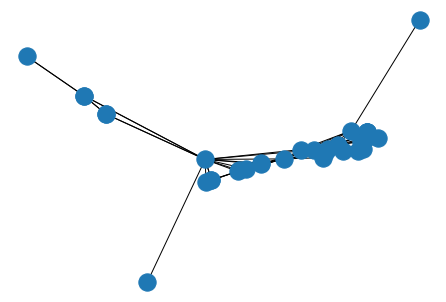

In [47]:
import networkx as nx
import pandas as pd

G = nx.read_edgelist("data/karate_edges.txt")
print(G.nodes())
nx.draw_spectral(G)

As we've seen before, graphs can always be represented as $n \times n$ matrices where entries denote the presence of an edge:

In [48]:
m = nx.adjacency_matrix(G, nodelist=[str(x) for x in range(1, len(G) + 1)])
print(m.shape)
m.todense()

(34, 34)


matrix([[0, 1, 1, ..., 1, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 1, 0]])

Here we're looking to classify the karate club members into one of two groups:

,node,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1
9,10,0


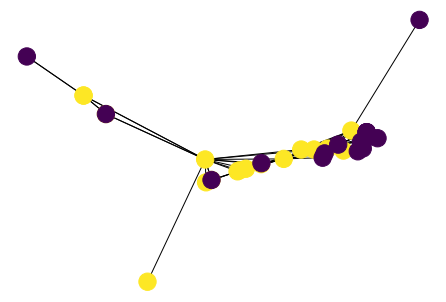

In [49]:
labels = pd.read_csv("data/karate_groups.txt", sep='\t', header=None)
labels.columns = ['node', 'label']
labels.label = (labels.label == 1).astype(int)
nx.draw_spectral(G, node_color=labels.label)
labels

In [50]:
import sklearn
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(m, labels.label)
lr.score(m, labels.label)

1.0

Of course, the model is **overspecified** when there are $n$ columns and $n$ rows. So typically we need to apply dimensionality reduction to a graph to ingest it into a regression problem:

In [7]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(5)
x = pca.fit_transform(m)
lr.fit(x, labels.label)
lr.score(x, labels.label)

0.9705882352941176

Note that since graphs are generally sparse matrices, not all algorithms work natively on the sparse matrix object.

You either need to convert it to a dense matrix, or find algorithms that work on sparse matrices.

Let's look at another graph:

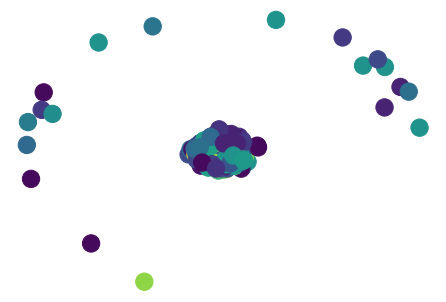

In [51]:
import gzip
import io
import requests

def make_email():
    """
    Graph from university emails, clustered by departments
    Data from http://snap.stanford.edu/data/email-Eu-core.html
    Edge list Format
    """
    res = requests.get('http://snap.stanford.edu/data/email-Eu-core.txt.gz', verify=False)
    edges = gzip.GzipFile(fileobj=io.BytesIO(res.content))
    edges = pd.read_csv(io.StringIO(edges.read().decode()), header=None, sep=' ')
    edges.columns = ['src', 'dest']
    # cluster labels per node
    res = requests.get('http://snap.stanford.edu/data/email-Eu-core-department-labels.txt.gz', verify=False)
    labels = gzip.GzipFile(fileobj=io.BytesIO(res.content))
    labels = pd.read_csv(io.StringIO(labels.read().decode()), header=None, sep=' ')
    labels.columns = ['node', 'cluster']
    G = nx.Graph()
    G.add_edges_from([(t.src, t.dest) for t in edges.itertuples()])
    return G, pd.DataFrame({'node': list(G), 'label': labels.cluster})


G, labels = make_email()
nx.draw(G, node_color=labels.label)

In [52]:
m = nx.adjacency_matrix(G, nodelist=[str(x) for x in range(1, len(G) + 1)])

pca = TruncatedSVD(5)
x = pca.fit_transform(m)

lr.fit(x, labels.label)
lr.score(x, labels.label)

/Users/mranger/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:197: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


0.10845771144278607

UMAP is one of the best default embedders for graphs:

In [53]:
import umap

pca = umap.UMAP(25)
x = pca.fit_transform(m)

lr.fit(x, labels.label)
lr.score(x, labels.label)

/Users/mranger/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.11641791044776119

Note that word embeddings are effectively the same as network embeddings, since the word co-occurence matrix is the same as a word co-occurence graph.

## Working with larger graphs

NetworkX is a great library, but has issues working with medium and large graphs ( >100,000 nodes), because it's built around the python list instead of the numpy array.

A good network embedding library based around networkx (for small graphs) is [karate club](https://github.com/benedekrozemberczki/KarateClub) 

**shameless self-promotion**

I've built a library to do representation learning on large graphs called `nodevectors` with an accompanying library to load large graphs `csrgraph`. 

Alternatives include [DGL](https://github.com/dmlc/dgl) based around graph neural networks (so complex to install and use, but extremely powerful) and [cleora](https://github.com/Synerise/cleora) (great but not a python library)

In [56]:
import csrgraph as cg
import nodevectors as nv

def read_bionev_labels(filename):
    """
    Reads multilabels in BioNEV format
    eg. node label1 label2 ... labeln
    ex.
        1 5 8 99 103
        2 4
        3 9 192 777
    Returns pd.DataFrame with nodeID
    """
    fin = open(filename, 'r')
    node_list = []
    labels = []
    while 1:
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split()
        node_list.append(int(vec[0]))
        labels.append([int(x) for x in vec[1:]])
    fin.close()
    res = pd.DataFrame({'nodes': node_list, 'mlabels':pd.Series(labels)})
    res = res.sort_values(by='nodes').reset_index(drop=True)
    res.nodes = res.nodes - 1
    if not (res.nodes == res.index).all():
        warnings.warn("There are some nodes without multilabels!")
    return res

labels = read_bionev_labels("data/bioNEV/node2vec_PPI/node2vec_PPI_labels.txt")

G = cg.read_edgelist("data/bioNEV/node2vec_PPI/node2vec_PPI.edgelist")
G.mat

<3890x3890 sparse matrix of type '<class 'numpy.float64'>'
	with 76584 stored elements in Compressed Sparse Row format>

This dataset has *multilabels* which we'll simplify to single classification labels for this problem:

In [57]:
labels['label'] = labels.mlabels.apply(lambda x : x[0])
labels

,nodes,mlabels,label
0,0,"[6, 16, 37, 39, 46]",6
1,1,[30],30
2,2,[5],5
3,3,[30],30
4,4,"[2, 9]",2
...,...,...,...
3885,3885,"[2, 35]",2
3886,3886,[26],26
3887,3887,"[4, 8, 21]",4
3888,3888,"[34, 38]",34


A great embedding algorithm for large graphs is **ProNE**:

In [61]:
pne = nv.ProNE(20)
x = pne.fit_transform(G)
print(x.shape)
lr.fit(x, labels.label)
lr.score(x, labels.label)

(3890, 20)


0.17223650385604114

An alternative (which is my creation) is **GGVec:**

In [62]:
ggvec = nv.GGVec(20)
x = ggvec.fit_transform(G)
print(x.shape)
lr.fit(x, labels.label)
lr.score(x, labels.label)

(3890, 20)


0.15372750642673522